<hr>
<h1>Predicting Abnormalities in Mammograms</h1>

<p>Jay Narhan</p>
May 2017

Screening for breast cancer will often make use of mammography as the primary imaging modality for early detection efforts. However identifying abnormalities is a difficult problem due to large variability in the appearance of normal and abnormal tissue in mammograms and due to the subtlety associated with abnormal manifestations. Indeed, the interpretation of mammography imaging is still a manual process that is prone to human error. The application of automated classification of mammography is <a href="http://www.sciencedirect.com/science/article/pii/S0169260715300110">described</a> as an unsolved problem. As such, this workbook aims to extend research into how machine learning technologies may supplement the <b>detection efforts</b> of radiologists.

Presented in this workbook are a number of models that have been developed to classify breast tissue imaging as either normal or abnormal, where abnormality contains benign and/or malignant lesions (masses or calcifications).

A number of preprocessing steps have been performed before application of these models. These steps include thresholding and segmentation of hardware artifacts from breast tissue. The preprocessing also includes the generation of difference images for every bilateral pairings of CC and MLO mammogram views for each patient in the data set. The data being used consists of these differenced images.

<hr>

In [1]:
import os
import sys
import time
import numpy as np

import sklearn.metrics as skm
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

from skimage import color

import keras.callbacks as cb
import keras.utils.np_utils as np_utils
from keras import applications
from keras import regularizers
from keras.models import Sequential
from keras.constraints import maxnorm
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Dense, Dropout, Flatten, GaussianNoise

from matplotlib import pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (10,10)
np.set_printoptions(precision=2)

sys.path.insert(0, '../helper_modules/')
import jn_bc_helper as bc

Using Theano backend.


<h2>Reproducible Research</h2>

In [2]:
%%python
import os
os.system('python -V')
os.system('python ../helper_modules/Package_Versions.py')

scipy:           0.19.0
numpy:           1.12.1
matplotlib:      2.0.0
sklearn:         0.18.1
skimage:         0.13.0
theano:          0.9.0.dev-c697eeab84e5b8a74908da654b66ec9eca4f1291
tensorflow:      0.10.0
keras:           2.0.3


Python 2.7.13 :: Continuum Analytics, Inc.
Using Theano backend.


In [3]:
SEED = 7
np.random.seed(SEED)

DATA_DIR = '/Users/jnarhan/Projects/CUNY_698/Docker-Shared/Data_Diff_Images/ALL_IMGS/'
meta_file = '../../Meta_Data_Files/meta_data_detection.csv'
PATHO_INX = 3   # Column number of detected label in meta_file
FILE_INX = 1    # Column number of File name in meta_file

meta_data, cls_cnts = bc.load_meta(meta_file, patho_idx=PATHO_INX, file_idx=FILE_INX,
                                   balanceByRemoval=True, verbose=True)

bc.pprint('Loading data:')
cats = bc.bcLabels(['normal', 'abnormal'])

# For smaller images supply tuple argument for a parameter 'imgResize':
X_data, Y_data = bc.load_data(meta_data, DATA_DIR, cats, imgResize=(150,150)) 


2it [00:00, 15.04it/s]

----------------
Before Balancing
----------------
abnormal  : 1472
normal    : 1072
balanceViaRemoval.avgC: 1272
balanceViaRemoval.theshold: 1272.0
---------------
After Balancing
---------------
abnormal  : 1172
normal    : 1072
-------------
Loading data:
-------------


2244it [01:31, 24.60it/s]


**Create the Training and Test Datasets**

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data,
                                                    test_size=0.25,
                                                    random_state=SEED,
                                                    stratify=zip(*Y_data)[0])

print 'Size of X_train: {:>5}'.format(len(X_train))
print 'Size of X_test: {:>5}'.format(len(X_test))
print 'Size of Y_train: {:>5}'.format(len(Y_train))
print 'Size of Y_test: {:>5}'.format(len(Y_test))

print X_train.shape
print X_test.shape
print Y_train.shape
print Y_test.shape

data = [X_train, X_test, Y_train, Y_test]

Size of X_train:  1683
Size of X_test:   561
Size of Y_train:  1683
Size of Y_test:   561
(1683, 150, 150)
(561, 150, 150)
(1683, 1)
(561, 1)


<h2>Support Vector Machine Model</h2>

In [11]:
X_train_svm = X_train.reshape( (X_train.shape[0], -1)) 
X_test_svm  = X_test.reshape( (X_test.shape[0], -1))

In [12]:
SVM_model = SVC(gamma=0.001)
SVM_model.fit( X_train_svm, Y_train)

/Users/jnarhan/miniconda2/envs/bc_venv/lib/python2.7/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [13]:
predictOutput = SVM_model.predict(X_test_svm)
svm_acc = metrics.accuracy_score(y_true=Y_test, y_pred=predictOutput)

print 'SVM Accuracy: {: >7.2f}%'.format(svm_acc * 100)
print 'SVM Error: {: >10.2f}%'.format(100 - svm_acc * 100)

SVM Accuracy:   85.03%
SVM Error:      14.97%


Normalized confusion matrix
[[ 0.83  0.17]
 [ 0.13  0.87]]


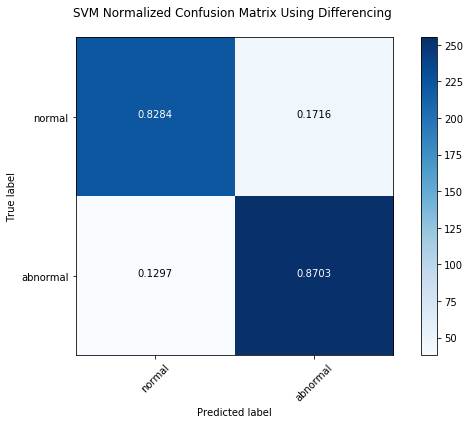

In [14]:
svm_matrix = skm.confusion_matrix(y_true=Y_test, y_pred=predictOutput)
numBC = bc.reverseDict(cats)
class_names = numBC.values()

plt.figure(figsize=(8,6))
bc.plot_confusion_matrix(svm_matrix, classes=class_names, normalize=True, 
                         title='SVM Normalized Confusion Matrix Using Differencing \n')
plt.tight_layout()
plt.savefig('./cm_figures/jn_SVM_2Class_CM_20170526.png', dpi=100)

Confusion matrix, without normalization
[[222  46]
 [ 38 255]]


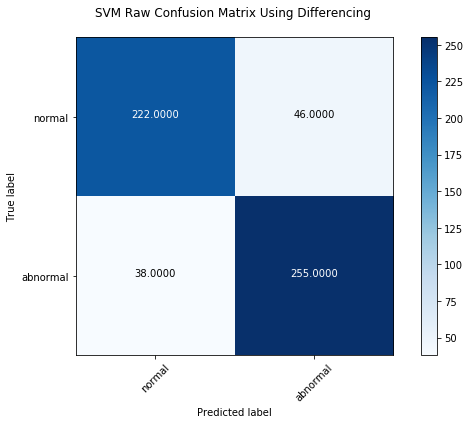

In [15]:
plt.figure(figsize=(8,6))
bc.plot_confusion_matrix(svm_matrix, classes=class_names, normalize=False, 
                         title='SVM Raw Confusion Matrix Using Differencing \n')
plt.tight_layout()

<h2>CNN Modelling Using VGG16 in Transfer Learning</h2>

In [5]:
def VGG_Prep(img_data):
    """
    :param img_data: training or test images of shape [#images, height, width]
    :return: the array transformed to the correct shape for the VGG network
                shape = [#images, height, width, 3] transforms to rgb and reshapes
    """
    images = np.zeros([len(img_data), img_data.shape[1], img_data.shape[2], 3])
    for i in range(0, len(img_data)):
        im = (img_data[i] * 255)        # Original imagenet images were not rescaled
        im = color.gray2rgb(im)
        images[i] = im
    return(images)

In [6]:
def vgg16_bottleneck(data, modelPath, fn_train_feats, fn_train_lbls, fn_test_feats, fn_test_lbls):
    # Loading data
    X_train, X_test, Y_train, Y_test = data
    
    print('Preparing the Training Data for the VGG_16 Model.')
    X_train = VGG_Prep(X_train)
    print('Preparing the Test Data for the VGG_16 Model')
    X_test = VGG_Prep(X_test)
        
    print('Loading the VGG_16 Model')
    # "model" excludes top layer of VGG16:
    model = applications.VGG16(include_top=False, weights='imagenet') 
        
    # Generating the bottleneck features for the training data
    print('Evaluating the VGG_16 Model on the Training Data')
    bottleneck_features_train = model.predict(X_train)
    
    # Saving the bottleneck features for the training data
    featuresTrain = os.path.join(modelPath, fn_train_feats)
    labelsTrain = os.path.join(modelPath, fn_train_lbls)
    print('Saving the Training Data Bottleneck Features.')
    np.save(open(featuresTrain, 'wb'), bottleneck_features_train)
    np.save(open(labelsTrain, 'wb'), Y_train)

    # Generating the bottleneck features for the test data
    print('Evaluating the VGG_16 Model on the Test Data')
    bottleneck_features_test = model.predict(X_test)
    
    # Saving the bottleneck features for the test data
    featuresTest = os.path.join(modelPath, fn_test_feats)
    labelsTest = os.path.join(modelPath, fn_test_lbls)
    print('Saving the Test Data Bottleneck Feaures.')
    np.save(open(featuresTest, 'wb'), bottleneck_features_test)
    np.save(open(labelsTest, 'wb'), Y_test)

In [7]:
# Locations for the bottleneck and labels files that we need
train_bottleneck = '2Class_VGG16_bottleneck_features_train.npy'
train_labels     = '2Class_VGG16_labels_train.npy'
test_bottleneck  = '2Class_VGG16_bottleneck_features_test.npy'
test_labels      = '2Class_VGG16_labels_test.npy'
modelPath = os.getcwd()

top_model_weights_path = './weights/'

np.random.seed(SEED)
vgg16_bottleneck(data, modelPath, train_bottleneck, train_labels, test_bottleneck, test_labels)

Preparing the Training Data for the VGG_16 Model.
Preparing the Test Data for the VGG_16 Model
Loading the VGG_16 Model
Evaluating the VGG_16 Model on the Training Data
Saving the Training Data Bottleneck Features.
Evaluating the VGG_16 Model on the Test Data
Saving the Test Data Bottleneck Feaures.


In [8]:
def train_top_model(train_feats, train_lab, test_feats, test_lab, model_path, model_save, epoch = 50, batch = 64):
    start_time = time.time()
    
    train_bottleneck = os.path.join(model_path, train_feats)
    train_labels = os.path.join(model_path, train_lab)
    test_bottleneck = os.path.join(model_path, test_feats)
    test_labels = os.path.join(model_path, test_lab)
    
    history = bc.LossHistory()
    
    X_train = np.load(train_bottleneck)
    Y_train = np.load(train_labels)
    Y_train = np_utils.to_categorical(Y_train, num_classes=2)
    
    X_test = np.load(test_bottleneck)
    Y_test = np.load(test_labels)
    Y_test = np_utils.to_categorical(Y_test, num_classes=2)

    model = Sequential()
    model.add(Flatten(input_shape=X_train.shape[1:]))
    model.add( Dropout(0.7))
    
    model.add( Dense(256, activation='relu', kernel_constraint= maxnorm(3.)) )
    model.add( Dropout(0.5))
    
    # Softmax for probabilities for each class at the output layer
    model.add( Dense(2, activation='softmax'))
    
    model.compile(optimizer='rmsprop',  # adadelta
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

    model.fit(X_train, Y_train,
              epochs=epoch,
              batch_size=batch,
              callbacks=[history],
              validation_data=(X_test, Y_test),
              verbose=2)
    
    print "Training duration : {0}".format(time.time() - start_time)
    score = model.evaluate(X_test, Y_test, batch_size=16, verbose=2)

    print "Network's test score [loss, accuracy]: {0}".format(score)
    print 'CNN Error: {:.2f}%'.format(100 - score[1] * 100)
    
    bc.save_model(model_save, model, "jn_VGG16_2Class_top_weights.h5")
    
    return model, history.losses, history.acc, score

Train on 1683 samples, validate on 561 samples
Epoch 1/100
1s - loss: 2.8385 - acc: 0.7986 - val_loss: 2.3598 - val_acc: 0.8485
Epoch 2/100
1s - loss: 2.7036 - acc: 0.8188 - val_loss: 2.3739 - val_acc: 0.8503
Epoch 3/100
1s - loss: 2.5971 - acc: 0.8265 - val_loss: 2.2746 - val_acc: 0.8503
Epoch 4/100
1s - loss: 2.5430 - acc: 0.8271 - val_loss: 2.1862 - val_acc: 0.8556
Epoch 5/100
1s - loss: 2.3917 - acc: 0.8372 - val_loss: 2.2429 - val_acc: 0.8538
Epoch 6/100
1s - loss: 2.4806 - acc: 0.8372 - val_loss: 2.4047 - val_acc: 0.8431
Epoch 7/100
1s - loss: 2.5464 - acc: 0.8271 - val_loss: 2.0646 - val_acc: 0.8610
Epoch 8/100
1s - loss: 2.3199 - acc: 0.8348 - val_loss: 1.9761 - val_acc: 0.8699
Epoch 9/100
1s - loss: 2.3834 - acc: 0.8324 - val_loss: 1.9468 - val_acc: 0.8627
Epoch 10/100
1s - loss: 2.3584 - acc: 0.8384 - val_loss: 1.9791 - val_acc: 0.8699
Epoch 11/100
1s - loss: 2.2034 - acc: 0.8532 - val_loss: 1.9340 - val_acc: 0.8681
Epoch 12/100
1s - loss: 2.2265 - acc: 0.8491 - val_loss: 1.9

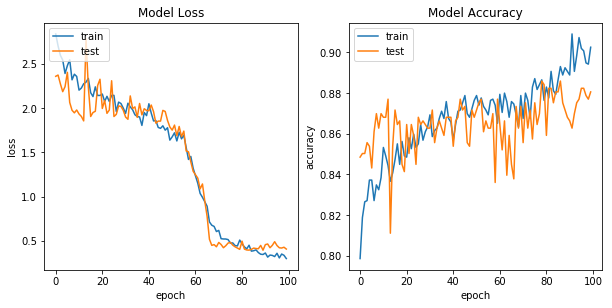

In [9]:
np.random.seed(SEED)
(trans_model, loss_cnn, acc_cnn, test_score_cnn) = train_top_model(train_feats=train_bottleneck,
                                                                   train_lab=train_labels, 
                                                                   test_feats=test_bottleneck, 
                                                                   test_lab=test_labels,
                                                                   model_path=modelPath, 
                                                                   model_save=top_model_weights_path,
                                                                   epoch=100)
plt.figure(figsize=(10,10))
bc.plot_losses(loss_cnn, acc_cnn)
plt.savefig('./epoch_figures/jn_Transfer_2Class_Learning_20170526.png', dpi=100)

Transfer Learning CNN Accuracy:   88.06%
Transfer Learning CNN Error:      11.94%
Normalized confusion matrix
[[ 0.88  0.12]
 [ 0.12  0.88]]


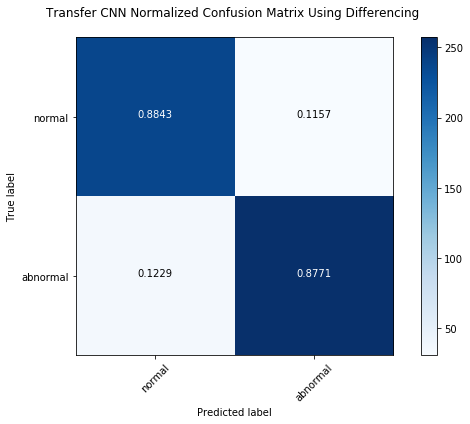

In [16]:
print 'Transfer Learning CNN Accuracy: {: >7.2f}%'.format(test_score_cnn[1] * 100)
print 'Transfer Learning CNN Error: {: >10.2f}%'.format(100 - test_score_cnn[1] * 100)

predictOutput = bc.predict(trans_model, np.load(test_bottleneck))
trans_matrix = skm.confusion_matrix(y_true=Y_test, y_pred=predictOutput)

plt.figure(figsize=(8,6))
bc.plot_confusion_matrix(trans_matrix, classes=class_names, normalize=True,
                         title='Transfer CNN Normalized Confusion Matrix Using Differencing \n')
plt.tight_layout()
plt.savefig('./cm_figures/jn_Transfer_2Class_CM_20170526.png', dpi=100)

Confusion matrix, without normalization
[[237  31]
 [ 36 257]]


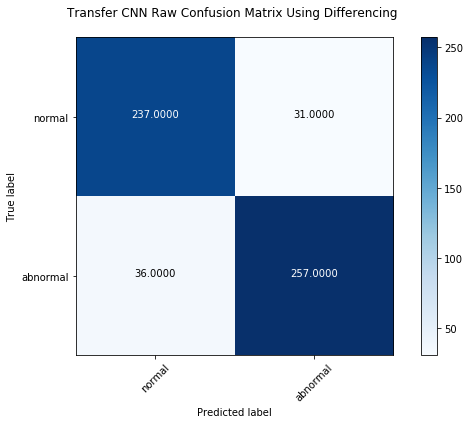

In [17]:
plt.figure(figsize=(8,6))
bc.plot_confusion_matrix(trans_matrix, classes=class_names, normalize=False,
                         title='Transfer CNN Raw Confusion Matrix Using Differencing \n')
plt.tight_layout()

<h2>Core CNN Modelling</h2>

**Prep and package the data for Keras processing:**

In [15]:
data = [X_train, X_test, Y_train, Y_test]
X_train, X_test, Y_train, Y_test = bc.prep_data(data, cats)
data = [X_train, X_test, Y_train, Y_test]

print X_train.shape
print X_test.shape
print Y_train.shape
print Y_test.shape

Prep data for NNs ...
Data Prepped for Neural Nets.
(1685, 1, 150, 150)
(562, 1, 150, 150)
(1685, 2)
(562, 2)


**Heavy Regularization**

In [16]:
def diff_model_v7_reg(numClasses, input_shape=(3, 150,150), add_noise=False, noise=0.01, verbose=False):
    model = Sequential()
    if (add_noise):
        model.add( GaussianNoise(noise, input_shape=input_shape))
        model.add( Convolution2D(filters=16, 
                                 kernel_size=(5,5), 
                                 data_format='channels_first',
                                 padding='same',
                                 activation='relu'))
    else:
        model.add( Convolution2D(filters=16, 
                                 kernel_size=(5,5), 
                                 data_format='channels_first',
                                 padding='same',
                                 activation='relu',
                                 input_shape=input_shape))
    model.add( Dropout(0.7))
    
    model.add( Convolution2D(filters=32, kernel_size=(3,3), 
                             data_format='channels_first', padding='same', activation='relu'))
    model.add( MaxPooling2D(pool_size= (2,2), data_format='channels_first'))
    model.add( Dropout(0.4))
    model.add( Convolution2D(filters=32, kernel_size=(3,3), 
                             data_format='channels_first', activation='relu'))
    
    model.add( Convolution2D(filters=64, kernel_size=(3,3), 
                             data_format='channels_first', padding='same', activation='relu',
                             kernel_regularizer=regularizers.l2(0.01)))
    model.add( MaxPooling2D(pool_size= (2,2), data_format='channels_first'))
    model.add( Convolution2D(filters=64, kernel_size=(3,3), 
                             data_format='channels_first', activation='relu',
                             kernel_regularizer=regularizers.l2(0.01)))
    model.add( Dropout(0.4))
    
    model.add( Convolution2D(filters=128, kernel_size=(3,3), 
                             data_format='channels_first', padding='same', activation='relu',
                             kernel_regularizer=regularizers.l2(0.01)))
    model.add( MaxPooling2D(pool_size= (2,2), data_format='channels_first'))
    
    model.add( Convolution2D(filters=128, kernel_size=(3,3), 
                             data_format='channels_first', activation='relu',
                             kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.4))
    
    model.add( Flatten())
    
    model.add( Dense(128, activation='relu', kernel_constraint= maxnorm(3.)) )
    model.add( Dropout(0.4))
    
    model.add( Dense(64, activation='relu', kernel_constraint= maxnorm(3.)) )
    model.add( Dropout(0.4))
    
    # Softmax for probabilities for each class at the output layer
    model.add( Dense(numClasses, activation='softmax'))
    
    if verbose:
        print( model.summary() )
    
    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    return model

In [17]:
diff_model7_noise_reg = diff_model_v7_reg(len(cats),
                                          input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]),
                                          add_noise=True, verbose=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise_1 (GaussianNo (None, 1, 150, 150)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 150, 150)      416       
_________________________________________________________________
dropout_3 (Dropout)          (None, 16, 150, 150)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 150, 150)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 75, 75)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 32, 75, 75)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 73, 73)        9248      
__________

Training model...
Train on 1685 samples, validate on 562 samples
Epoch 1/50
170s - loss: 2.3927 - acc: 0.7104 - val_loss: 1.5572 - val_acc: 0.7082
Epoch 2/50
167s - loss: 1.0973 - acc: 0.8071 - val_loss: 0.8139 - val_acc: 0.7758
Epoch 3/50
167s - loss: 0.6356 - acc: 0.8202 - val_loss: 0.5574 - val_acc: 0.8292
Epoch 4/50
166s - loss: 0.5129 - acc: 0.8273 - val_loss: 0.4809 - val_acc: 0.8327
Epoch 5/50
166s - loss: 0.4813 - acc: 0.8243 - val_loss: 0.4653 - val_acc: 0.8345
Epoch 6/50
165s - loss: 0.4605 - acc: 0.8267 - val_loss: 0.4479 - val_acc: 0.8381
Epoch 7/50
166s - loss: 0.4403 - acc: 0.8291 - val_loss: 0.4530 - val_acc: 0.8363
Epoch 8/50
167s - loss: 0.4484 - acc: 0.8267 - val_loss: 0.4684 - val_acc: 0.8132
Epoch 9/50
167s - loss: 0.4479 - acc: 0.8279 - val_loss: 0.4457 - val_acc: 0.8381
Epoch 10/50
167s - loss: 0.4310 - acc: 0.8350 - val_loss: 0.5219 - val_acc: 0.7669
Epoch 11/50
167s - loss: 0.4277 - acc: 0.8344 - val_loss: 0.4430 - val_acc: 0.8274
Epoch 12/50
167s - loss: 0.4178

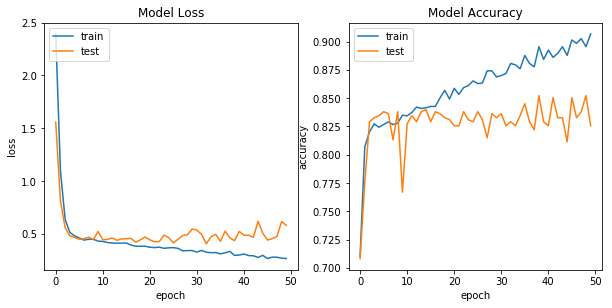

In [18]:
np.random.seed(SEED)

(cnn_model, loss_cnn, acc_cnn, test_score_cnn) = bc.run_network(model=diff_model7_noise_reg, 
                                                                data=data, 
                                                                epochs=50, batch=64)
plt.figure(figsize=(10,10))
bc.plot_losses(loss_cnn, acc_cnn)
plt.savefig('./epoch_figures/jn_Core_CNN_2Class_Learning_20170508.png', dpi=100)

In [19]:
bc.save_model(dir_path='./weights/', model=cnn_model, name='jn_Core_CNN_2Class_20170508')

Model and Weights Saved to Disk


Core CNN Accuracy:   82.56%
Core CNN Error:      17.44%
Normalized confusion matrix
[[ 0.83  0.17]
 [ 0.18  0.82]]


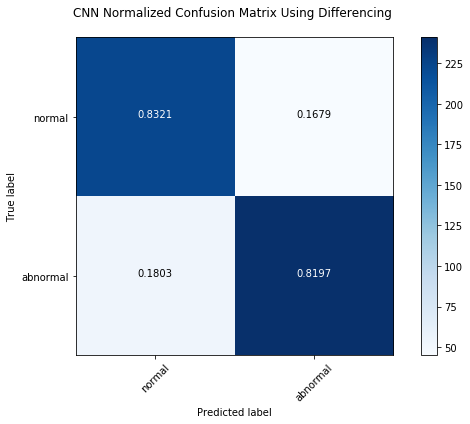

In [20]:
print 'Core CNN Accuracy: {: >7.2f}%'.format(test_score_cnn[1] * 100)
print 'Core CNN Error: {: >10.2f}%'.format(100 - test_score_cnn[1] * 100)

predictOutput = bc.predict(cnn_model, X_test)

cnn_matrix = skm.confusion_matrix(y_true=[val.argmax() for val in Y_test], y_pred=predictOutput)

plt.figure(figsize=(8,6))
bc.plot_confusion_matrix(cnn_matrix, classes=class_names, normalize=True,
                         title='CNN Normalized Confusion Matrix Using Differencing \n')
plt.tight_layout()
plt.savefig('./cm_figures/jn_Core_CNN_2Class_CM_20170508.png', dpi=100)

In [ ]:
plt.figure(figsize=(8,6))
bc.plot_confusion_matrix(cnn_matrix, classes=class_names, normalize=False,
                         title='CNN Raw Confusion Matrix Using Differencing \n')
plt.tight_layout()